In [1]:
from datasets import load_dataset
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [2]:
# Download the dataset
dataset = load_dataset("danavery/urbansound8K", split="train")

In [3]:
dataset

Dataset({
    features: ['audio', 'slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class'],
    num_rows: 8732
})

In [4]:
# Prepare containers
lengths = []
sampling_rates = Counter()
salience_counts = Counter()
fold_counts = Counter()
class_counts = Counter()
class_salience_counts = defaultdict(lambda: Counter())
first_part_ids = []

for row in tqdm(dataset, total=len(dataset)):
    audio = row['audio']
    length = len(audio['array']) / audio['sampling_rate']
    lengths.append(length)
    sampling_rates[audio['sampling_rate']] += 1
    salience_counts[row['salience']] += 1
    fold_counts[row['fold']] += 1
    class_counts[row['class']] += 1
    class_salience_counts[row['class']][row['salience']] += 1
    first_part = row['audio']['path'].split('-')[0]
    first_part_ids.append(first_part)

# Length stats
min_length = np.min(lengths)
max_length = np.max(lengths)
avg_length = np.mean(lengths)
std_length = np.std(lengths)

print(f"Length stats (seconds): min={min_length:.2f}, max={max_length:.2f}, avg={avg_length:.2f}, std={std_length:.2f}")
print(f"Sampling rates in dataset: {dict(sampling_rates)}")
print(f"Salience counts: {dict(salience_counts)}")
print(f"Fold counts: {dict(fold_counts)}")
print(f"Class counts: {dict(class_counts)}")
print("Per class, salience breakdown:")
for cls, sal_counts in class_salience_counts.items():
    print(f"  {cls}: salience=1 (foreground): {sal_counts[1]}, salience=2 (background): {sal_counts[2]}")

  0%|          | 0/8732 [00:00<?, ?it/s]

Length stats (seconds): min=0.05, max=4.04, avg=3.61, std=0.97
Sampling rates in dataset: {44100: 5370, 48000: 2502, 96000: 610, 22050: 44, 16000: 45, 11025: 39, 192000: 17, 32000: 4, 11024: 7, 24000: 82, 8000: 12}
Salience counts: {1: 5702, 2: 3030}
Fold counts: {5: 936, 10: 837, 2: 888, 6: 823, 1: 873, 9: 816, 7: 838, 4: 990, 3: 925, 8: 806}
Class counts: {'dog_bark': 1000, 'children_playing': 1000, 'car_horn': 429, 'air_conditioner': 1000, 'street_music': 1000, 'gun_shot': 374, 'siren': 929, 'engine_idling': 1000, 'jackhammer': 1000, 'drilling': 1000}
Per class, salience breakdown:
  dog_bark: salience=1 (foreground): 645, salience=2 (background): 355
  children_playing: salience=1 (foreground): 588, salience=2 (background): 412
  car_horn: salience=1 (foreground): 153, salience=2 (background): 276
  air_conditioner: salience=1 (foreground): 569, salience=2 (background): 431
  street_music: salience=1 (foreground): 625, salience=2 (background): 375
  gun_shot: salience=1 (foreground

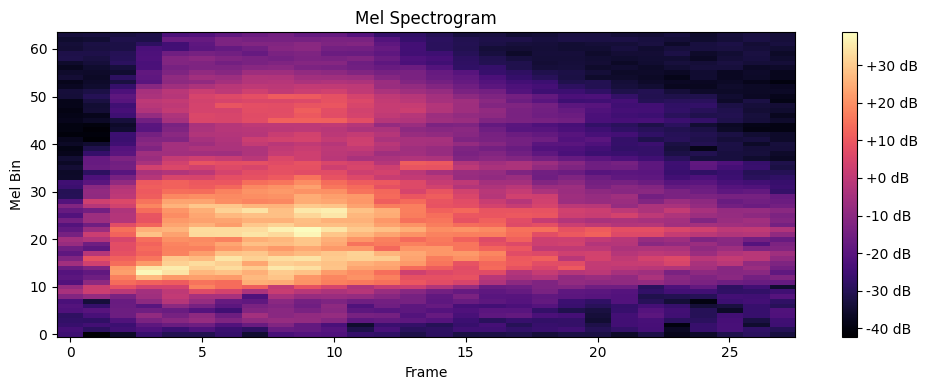

In [5]:
# Parameters for MelSpectrogram
SAMPLE_RATE = 44100  # or use dataset[0]['audio']['sampling_rate']
N_FFT = 1024
HOP_LENGTH = 512
NUM_MELS = 64

# Get the first row
row = dataset[0]
audio_array = row['audio']['array']
sample_rate = row['audio']['sampling_rate']

# Convert to torch tensor (float32)
waveform = torch.tensor(audio_array, dtype=torch.float32).unsqueeze(0)  # shape: (1, num_samples)

# Create MelSpectrogram transform
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=NUM_MELS
)

# Compute Mel spectrogram
mel_spec = mel_transform(waveform)

# Convert to decibels for visualization
mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram')
plt.xlabel('Frame')
plt.ylabel('Mel Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [6]:
display(Audio(audio_array, rate=sample_rate))